### 1. Get data set and view qty

In [1]:
import os
import glob

basedir = 'vehicles/'
img_types = os.listdir(basedir)
cars = []
for img_type in img_types:
    cars.extend(glob.glob(basedir+img_type+"/*"))
    
print('vehicles found', len(cars))

with open("cars.txt",'w') as f:
    for fn in cars:
        f.write(fn+'\n')
        
basedir = 'non-vehicles/'
img_types = os.listdir(basedir)
notcars = []
for img_type in img_types:
    notcars.extend(glob.glob(basedir+img_type+"/*"))
    
print('non-vehicles found', len(notcars))

with open("notcars.txt",'w') as f:
    for fn in notcars:
        f.write(fn+'\n')
        

vehicles found 8792
non-vehicles found 8968


In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


### 2. Extract features from image, HOG, Spatial and Color

In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [4]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0],size).ravel()
    color2 = cv2.resize(img[:,:,1],size).ravel()
    color3 = cv2.resize(img[:,:,2],size).ravel()
    return np.hstack((color1,color2,color3))

# Define a function to compute color histogram features  
def color_hist(img, nbins=32):#bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [5]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-nx_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### 3. Function for getting features for single image

In [6]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis = False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))  
            hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features,hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [7]:
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows,cols,i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img,cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

In [8]:
%matplotlib inline

### 4. View HOG for sample image

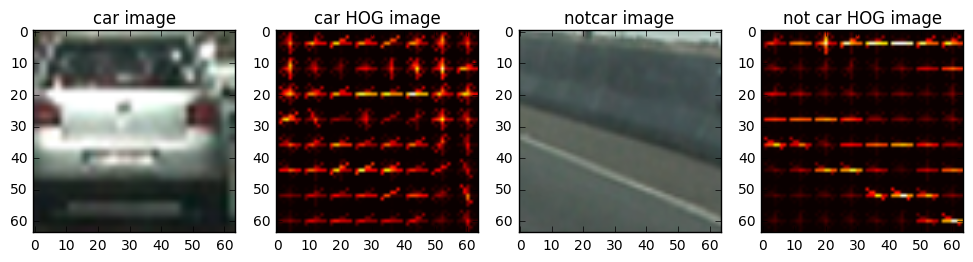

In [9]:
car_ind = np.random.randint(0,len(cars))
notcar_ind = np.random.randint(0,len(notcars))

car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

color_space = 'RGB'
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0
spatial_size = (16,16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

car_features, car_hog_image = single_img_features(car_image,color_space = color_space, spatial_size = spatial_size,
                                                hist_bins = hist_bins, orient = orient, pix_per_cell = pix_per_cell,
                                                cell_per_block = cell_per_block, hog_channel = hog_channel,
                                                spatial_feat = spatial_feat,hist_feat = hist_feat,hog_feat = hog_feat,
                                                vis = True)
notcar_features, notcar_hog_image = single_img_features(notcar_image,color_space = color_space, spatial_size = spatial_size,
                                                hist_bins = hist_bins, orient = orient, pix_per_cell = pix_per_cell,
                                                cell_per_block = cell_per_block, hog_channel = hog_channel,
                                                spatial_feat = spatial_feat,hist_feat = hist_feat,hog_feat = hog_feat,
                                                vis = True)
images = [car_image,car_hog_image,notcar_image,notcar_hog_image]
titles = ['car image', 'car HOG image', 'notcar image', 'not car HOG image']
fig = plt.figure(figsize=(12,3))
visualize(fig,1,4,images,titles)


### 5 . Train classifier on extracted image features

In [10]:
color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'#0,1,2,All
spatial_size = (16,16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

t = time.time()
n_samples = 20000
random_idxs = np.random.randint(0,len(cars),n_samples)
test_cars = np.array(cars)[random_idxs]
test_notcars = np.array(notcars)[random_idxs]

car_features = extract_features(test_cars, color_space = color_space,
                               spatial_size = spatial_size,hist_bins = hist_bins,
                               orient = orient,pix_per_cell = pix_per_cell,
                               cell_per_block = cell_per_block,
                               hog_channel = hog_channel,spatial_feat = spatial_feat,
                               hist_feat = hist_feat,hog_feat = hog_feat)

notcar_features = extract_features(test_notcars, color_space = color_space,
                               spatial_size = spatial_size,hist_bins = hist_bins,
                               orient = orient,pix_per_cell = pix_per_cell,
                               cell_per_block = cell_per_block,
                               hog_channel = hog_channel,spatial_feat = spatial_feat,
                               hist_feat = hist_feat,hog_feat = hog_feat)

print(time.time()-t,'seconds to compute features')

X = np.vstack((car_features,notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)),np.zeros(len(notcar_features))))

rand_state = np.random.randint(0,100)
X_train,X_test,y_train,y_test = train_test_split(scaled_X,y,test_size = .1,random_state = rand_state)

print('Using:',orient,'orientations,',pix_per_cell,'pixels per cell,', cell_per_block,'cells per block,',
     hist_bins,'histogram bins and ', spatial_size,' spatial sampling')
print('Feature vector length:',len(X_train[0]))

svc = LinearSVC()
t = time.time()
svc.fit(X_train,y_train)
print(round(time.time()-t,2), 'Seconds to train SVC')
print('Test accuracy of SVC = ', round(svc.score(X_test,y_test),4))

128.82302570343018 seconds to compute features
Using: 9 orientations, 8 pixels per cell, 2 cells per block, 16 histogram bins and  (16, 16)  spatial sampling
Feature vector length: 6108
28.99 Seconds to train SVC
Test accuracy of SVC =  0.998


### 6. Test classifier on examples images

0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
1487962154.3937387 seconds to process one image searching 273 windows


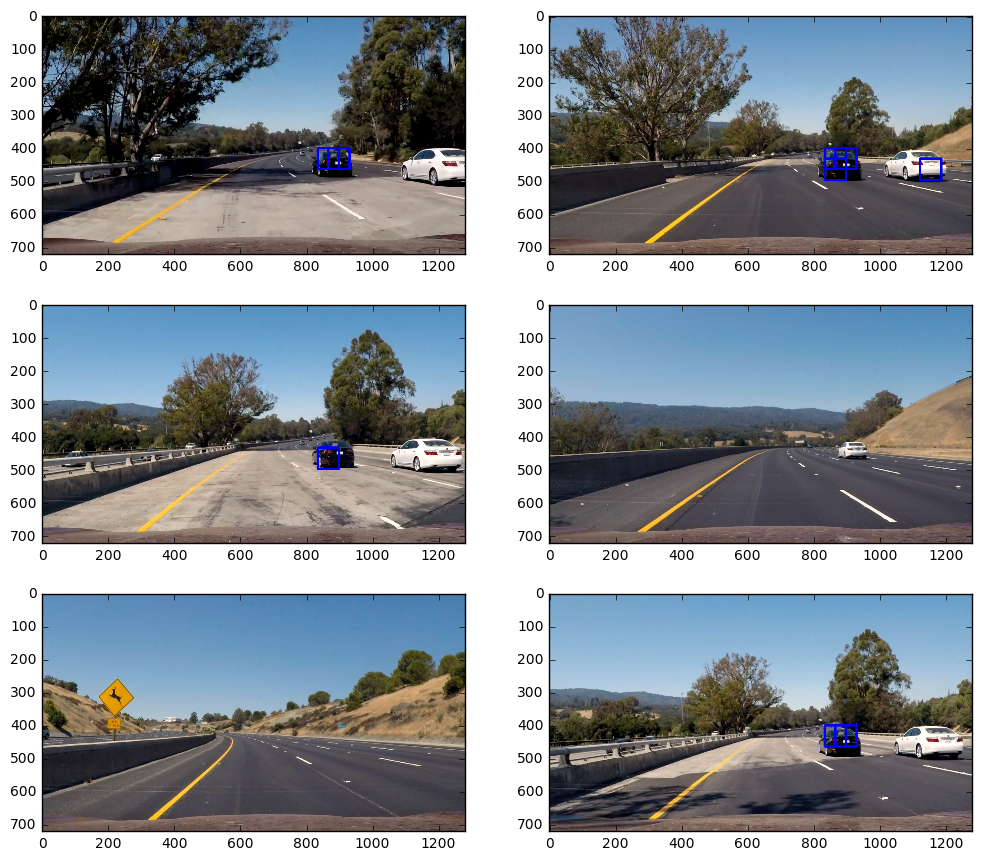

In [11]:
searchpath = 'test_images/*'
example_images = glob.glob(searchpath)
images = []
titles = []
y_start_stop = [400,656]
overlap = 0.5
for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    print(np.min(img),np.max(img))
    
    windows = slide_window(img,x_start_stop=[None,None], y_start_stop = y_start_stop,
                          xy_window = (64,64),xy_overlap = (overlap,overlap))
    
    hot_windows = search_windows(img,windows,svc,X_scaler,color_space = color_space,spatial_size = spatial_size,
                                hist_bins = hist_bins,orient = orient,pix_per_cell = pix_per_cell,
                                cell_per_block = cell_per_block,
                                hog_channel = hog_channel, spatial_feat = spatial_feat,
                                hist_feat = hist_feat, hog_feat = hog_feat)
    window_img = draw_boxes(draw_img,hot_windows,color = (0,0,255), thick=6)
    images.append(window_img)
    titles.append('')
print(time.time()-1,'seconds to process one image searching',len(windows),'windows')
fig = plt.figure(figsize=(12,18),dpi=300)
visualize(fig,5,2,images,titles)

In [12]:
def convert_color(img,conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img,cv2.COLOR_RGB2LUV)

### 7. Routine to resize image to mimic taking various sizes or scales of window samples from the image to feed to our classifier

0.2654409408569336 seconds to run, total windows =  294
(720, 1280)
0.24436521530151367 seconds to run, total windows =  294
(720, 1280)
0.2448868751525879 seconds to run, total windows =  294
(720, 1280)
0.24403762817382812 seconds to run, total windows =  294
(720, 1280)
0.2778441905975342 seconds to run, total windows =  294
(720, 1280)
0.23609185218811035 seconds to run, total windows =  294
(720, 1280)


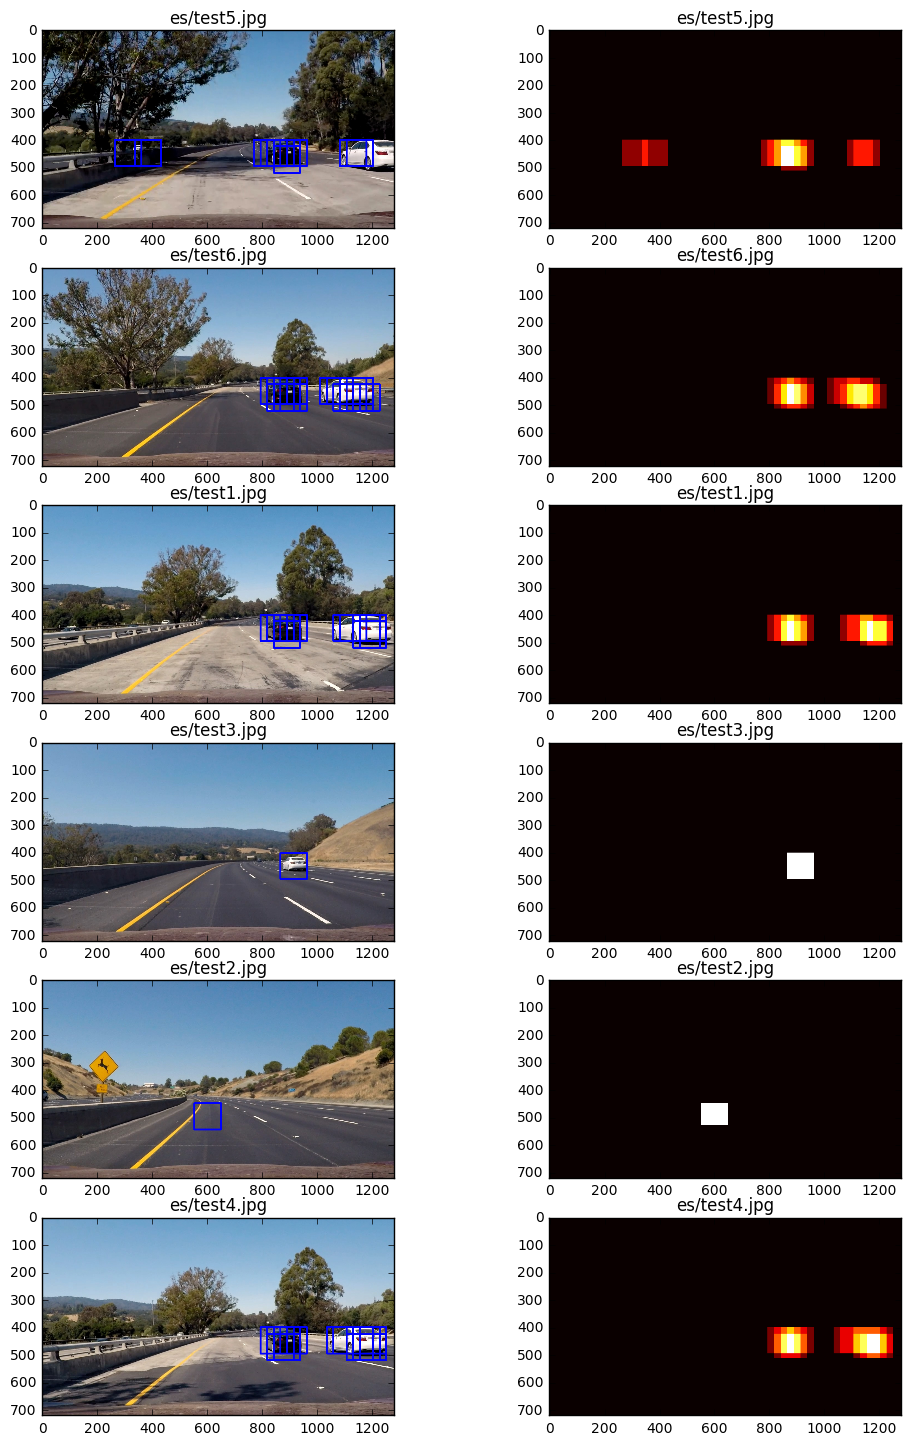

In [13]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []

ystart = 400
ystop = 656
scale = 1.5

for img_src in example_images:
    img_boxes = []2
    t = time.time()
    count = 0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch,(np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    nxblocks = (ch1.shape[1] // pix_per_cell) -1
    nyblocks = (ch1.shape[0] // pix_per_cell) -1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) -1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    hog1 = get_hog_features(ch1,orient,pix_per_cell,cell_per_block,feature_vec = False)
    hog2 = get_hog_features(ch2,orient,pix_per_cell,cell_per_block,feature_vec = False)
    hog3 = get_hog_features(ch3,orient,pix_per_cell,cell_per_block,feature_vec = False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count +=1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1,hog_feat2,hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window,xleft:xleft+window],(64,64))
            
            spatial_features = bin_spatial(subimg,size=spatial_size)
            hist_features = color_hist(subimg,nbins=hist_bins)
            
            #print(spatial_features.shape)
            #print(hist_features.shape)
            #print(hog_features.shape)
            
            combined = np.hstack((spatial_features,hist_features,hog_features)).reshape(1,-1)
            #print(combined.shape)
            
            test_features = X_scaler.transform(combined)
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left,ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                img_boxes.append(((xbox_left,ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop+win_draw+ystart,xbox_left:xbox_left+win_draw] +=1
                
    print(time.time() - t, 'seconds to run, total windows = ',count)
            
    out_images.append(draw_img)
            
    out_titles.append(img_src[-12:])
    out_titles.append(img_src[-12:])
            
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)
    print(heatmap.shape) 
fig = plt.figure(figsize=(12,24))
visualize(fig,8,2,out_images,out_titles)        

### 8. Wrapping the above windows generator into a reusable function that returns heatmaps

In [96]:
def find_cars(img, scale,ystart,ystop,draw_all = False, color = (0,0,255),thick = 6):
    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch,conv = 'RGB2YCrCb')
    if scale !=1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch,(np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    nxblocks = (ch1.shape[1] // pix_per_cell) -1
    nyblocks = (ch1.shape[0] // pix_per_cell) -1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) -1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    hog1 = get_hog_features(ch1,orient,pix_per_cell,cell_per_block,feature_vec = False)
    hog2 = get_hog_features(ch2,orient,pix_per_cell,cell_per_block,feature_vec = False)
    hog3 = get_hog_features(ch3,orient,pix_per_cell,cell_per_block,feature_vec = False)
   
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1,hog_feat2,hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window,xleft:xleft+window],(64,64))
            
            spatial_features = bin_spatial(subimg,size=spatial_size)
            hist_features = color_hist(subimg,nbins=hist_bins)
            
            #print(spatial_features.shape)
            #print(hist_features.shape)
            #print(hog_features.shape)
            
            combined = np.hstack((spatial_features,hist_features,hog_features)).reshape(1,-1)
            #print(combined.shape)
            
            test_features = X_scaler.transform(combined)
            test_prediction = svc.predict(test_features)
            if draw_all == True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left,ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),color,thick) 
             
                
            if test_prediction == 1:
                #print('some cares found')
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left,ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(255,255,255),6)
                img_boxes.append(((xbox_left,ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop+win_draw+ystart,xbox_left:xbox_left+win_draw] +=1
    #print('img shape:',img.shape)
    #print('heatmap shape:',heatmap.shape)
    return draw_img, heatmap
        

### 9. Some helper functions to draw bounding boxes onto images and convert stacked heat maps to single boxes

In [16]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap,threshold):
    heatmap[heatmap<=threshold] = 0
    #heatmap[heatmap>threshold] = 1
    return heatmap

def get_boxes_from_labels(labels):
    bboxes = []
    for car_number in range(1,labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        #print(nonzero)
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        bbox = ((np.min(nonzerox),np.min(nonzeroy)),(np.max(nonzerox),np.max(nonzeroy)))
        bboxes.append(bbox)
    return bboxes

def draw_boxes(img,bboxes):
    for bbox in bboxes:
        cv2.rectangle(img,bbox[0],bbox[1],(0,0,255),6)
    return img

def draw_labeled_bboxes(img,labels):
    #print(labels)
    for car_number in range(1,labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        #print(nonzero)
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        bbox = ((np.min(nonzerox),np.min(nonzeroy)),(np.max(nonzerox),np.max(nonzeroy)))
        cv2.rectangle(img,bbox[0],bbox[1],(0,0,255),6)
    return img

### 10. Test various subwindow parameters with our classifier on our exampls images

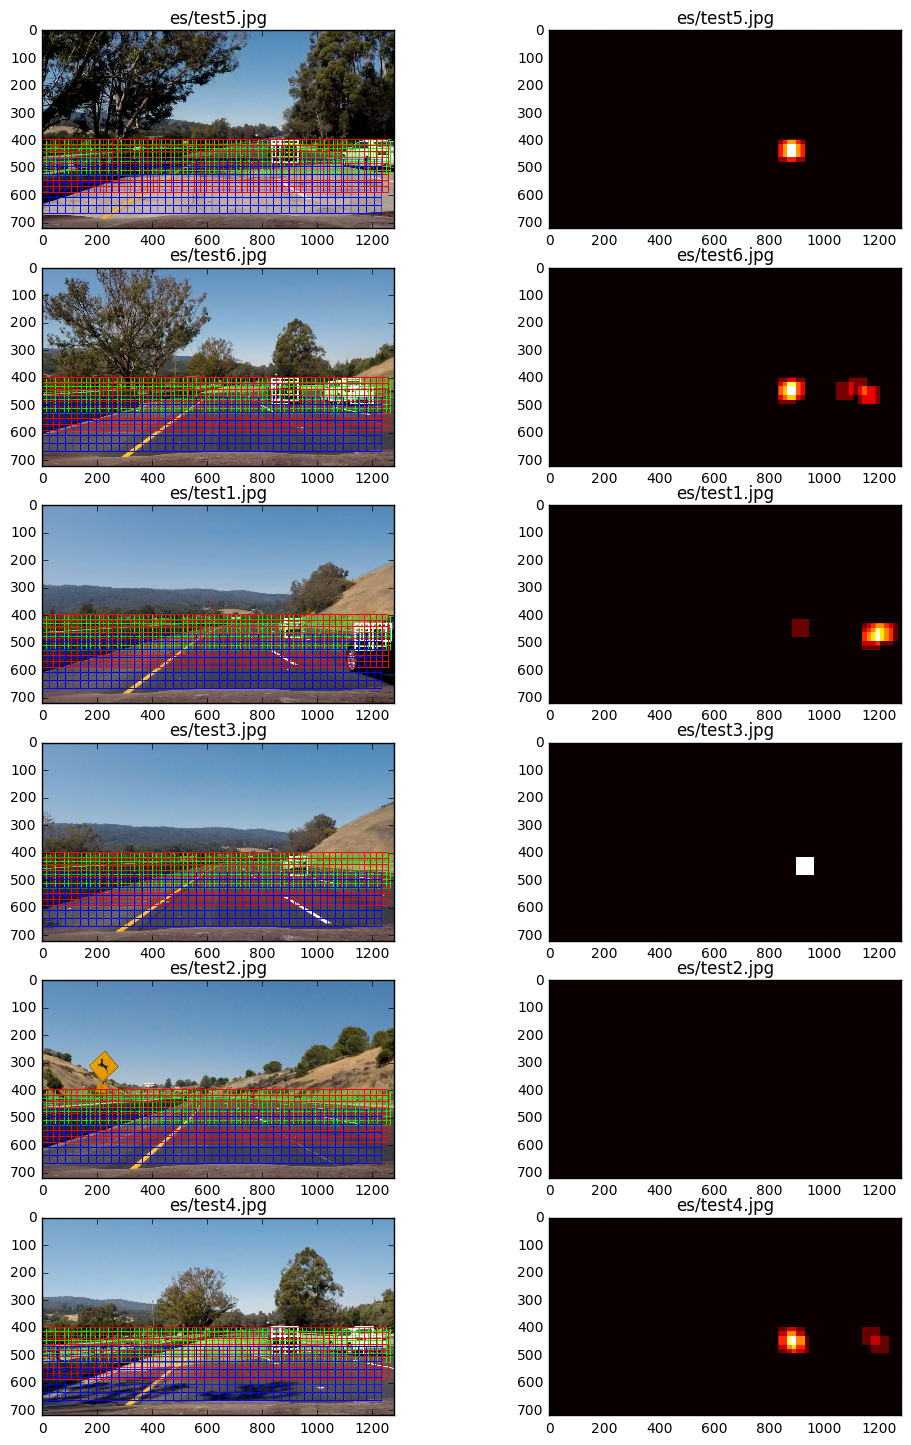

In [135]:
out_images = []
out_maps = []
ystart = 400
ystop = 500
scale = 1
for img_src in example_images:
    img = mpimg.imread(img_src)
    out_img,heat_map1 = find_cars(img,1,400,550,draw_all = True,color = (0,255,0),thick = 2)
    out_img,heat_map2 = find_cars(out_img,1.33,400,620,draw_all = True,color = (255,0,0),thick = 2)
    out_img,heat_map3 = find_cars(out_img,1.75,470,720,draw_all = True,color = (0,0,255),thick = 2)

    heat_map = heat_map1 + heat_map2 +heat_map3
    labels = label(heat_map)
    #print(heat_map.shape)
    #print(labels)
    draw_img = draw_labeled_bboxes(np.copy(img),labels)
    out_images.append(out_img)
    out_images.append(heat_map)

fig = plt.figure(figsize = (12,24))
visualize(fig,8,2,out_images,out_titles)

### 11. Routine to combine previous heatmaps and merge them into current

In [132]:
num_max_saved_heatmaps = 10
heat_map_combined_threshold = num_max_saved_heatmaps * 1
combined_heatmap = []

def insert_get_combined_heatmap(frame_heatmap):
    #print(frame_heatmap.shape)
    global combined_heatmap
    
    #print(len(combined_heatmap))
    if len(combined_heatmap) >= num_max_saved_heatmaps:
        combined_heatmap.pop(0)
    combined_heatmap.append(frame_heatmap)
    #print(np.array(combined_heatmap).shape)
    
    return np.sum(combined_heatmap, axis=0)
    
    

### 12. Pipleline for processing images

In [128]:
count = 0
def process_image(img):
    global count
    count = count + 1
    #s = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    #cv2.imwrite("test/"+str(count)+"_img.jpg", s)
    _, heat_map1 = find_cars(img,1,400,550)
    _, heat_map2 = find_cars(img,1.33,400,620)
    _, heat_map3 = find_cars(img,1.75,470,720)
    #_, heat_map4 = find_cars(img,.5,400,500)
    #_, heat_map5 = find_cars(img,.25)
    
    heat_map = heat_map1 + heat_map2 + heat_map3 #+ heat_map4 #+ heat_map5
    #print(heat_map)
    heat_map = insert_get_combined_heatmap(heat_map)
    #print(np.array(combined_heatmap).shape)
    #print(np.max(heat_map))
    #print(heat_map.shape)
    #print(heat_map2.shape)
    heat_map = apply_threshold(heat_map,heat_map_combined_threshold)
    labels = label(heat_map)
    #print(len(labels))
    draw_img = draw_labeled_bboxes(np.copy(img),labels)
    #s = cv2.cvtColor(draw_img, cv2.COLOR_RGB2BGR)
    #cv2.imwrite("test/"+str(count)+"_img_res.jpg", s)
    return draw_img

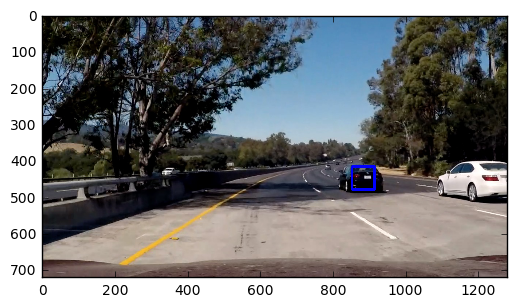

In [129]:
combined_heatmap = []
img = mpimg.imread(example_images[0])
i = process_image(img)
#print(i.shape)
plt.imshow(i)
#plt.show()

In [ ]:
#import imageio
#imageio.plugins.ffmpeg.download()

### 13. Process Video

In [133]:
combined_heatmap = []
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'test.mp4'
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output,audio=False)

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


100%|█████████▉| 1260/1261 [14:47<00:00,  1.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 



In [134]:
HTML("""
<video width="960" height="540" controls><source src="{0}"></video>
""".format(test_output))